In [1]:
#%run ../Getting_data/Getting_Data.ipynb

In [2]:
import datetime as dt
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [50, 15]
from pandas_profiling import ProfileReport

In [3]:
def plot_year_x(year,df,column):
    """
    With this function we will plot the time series of the year that we indicate.
    """
    # We create the dataframe to plot
    plot=df[df['datetime'].dt.year==year][[column,'datetime']]
    # We plot the dataframe
    sns.lineplot(x='datetime',y=column,data=plot)

def plot_all_years(df,column,resampling='D'):
    """
    With this function we will plot all the years, resampled by the period we indicate. The values shown will be the 
    mean of the period
    """
    # We create the dataframe to plot
    df_aux=df.set_index('datetime')[column].resample(resampling).mean()
    # We plot the dataframe
    sns.lineplot(x=df_aux.index,y=df_aux)  

In [4]:
df = pd.read_csv('TFM_dataframe.csv',parse_dates=['datetime','datetime_utc','tz_time'])

### Time series index

In [5]:
df = df.set_index('datetime')

### Calculations based on other columns

It may be useful the use of the weekday

In [6]:
df['Weekday']=df.index.strftime('%A')
df['Hour']=df.index.hour

### Fill NaN values

In [7]:
df[['Red_Electrica','IBEX35']]=df[['Red_Electrica','IBEX35']].ffill()

In [8]:
df.drop(['hour','quarter','Consumer_price_index', 'Time_required_to_get_electricity_(days)',
       'Inflation,consumer_prices_(annual_%)','Employment_in_industry_(%_of_total_employment)','geo_id','geo_name',
       'PIB_Trimestral', 'Var_Trim_PIB_(%)', 'Var_anual_PIB_Trim_(%)','datetime_utc','tz_time'],axis=1,inplace=True)

We may interpolate for those values missing for the market spot price:

In [9]:
df['Precio_mercado_SPOT_Intradiario_Sesion_1']=df['Precio_mercado_SPOT_Intradiario_Sesion_1'].interpolate(method='linear', limit_area='inside')
df['Precio_mercado_SPOT_Intradiario_Sesion_2']=df['Precio_mercado_SPOT_Intradiario_Sesion_2'].interpolate(method='linear', limit_area='inside')

We may consider that if the programmed generation of power is null it may be because it is considered 0:

In [10]:
df[df.columns[pd.Series(df.columns).str.contains('Correccion|Generacion')]]=df[df.columns[pd.Series(df.columns).str.contains('Correccion|Generacion')]].fillna(0)

If we want to consider the effect of the date, we need to create a column in which we will put the day, another one for the month and the last one for the year.

Let's merge all the columns for the generation of power:

In [11]:
idx = df.columns.str.startswith('Generacion')
df['Generacion'] = df.iloc[:,idx].sum(axis=1)

In [12]:
idx = df.columns.str.startswith('Demanda')
df['Demanda'] = df.iloc[:,idx].sum(axis=1)

In [13]:
df.corr().style.background_gradient(cmap='coolwarm')

In [14]:
y_corr = df.corr()['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
y_corr[(y_corr>0.3)|(y_corr<-0.3)]

Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)    1.000000
Demanda_programada_P48_total                                                     0.572930
Precio_mercado_SPOT_Diario                                                       0.544875
Precio_mercado_SPOT_Intradiario_Sesion_1                                         0.535016
Precio_mercado_SPOT_Intradiario_Sesion_2                                         0.528049
Generacion_programada_P48_Ciclo_combinado                                        0.301183
Generacion_programada_P48_Consumo_bombeo                                         0.418261
Generacion_programada_P48_Enlace_Baleares                                       -0.464007
Generacion_programada_P48_Gas_Natural_Cogeneracion                               0.328921
Generacion_programada_P48_Hulla_antracita                                        0.301094
Generacion_programada_P48_Hulla_sub-bituminosa                                   0.344283
Generacion

In [15]:
idx = df.columns.str.startswith('Generacion_')
df['Generacion_corr'] = df.iloc[:,idx].sum(axis=1)

### Statistics

In [16]:
df.describe()

,Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA),Demanda_programada_P48_total,Precio_mercado_SPOT_Diario,Precio_mercado_SPOT_Intradiario_Sesion_1,Precio_mercado_SPOT_Intradiario_Sesion_2,Demanda_programada_P48_Correccion_eolica,Demanda_programada_P48_Correccion_solar,Generacion_programada_P48_Biogas,Generacion_programada_P48_Biomasa,Generacion_programada_P48_Ciclo_combinado,...,day,month,year,holidays,Red_Electrica,IBEX35,Hour,Generacion,Demanda,Generacion_corr
count,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,...,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000
mean,92.264796,28274.804681,47.645704,47.341215,47.317518,-19.243090,-46.390311,64.896705,393.865351,3551.653085,...,15.682227,6.464098,2016.857972,0.022037,13.952407,9664.200751,11.499596,27689.461112,28209.171280,27689.461112
std,39.056999,4675.215643,14.887291,14.994888,15.019109,464.274961,234.634058,40.782189,108.387248,2443.451037,...,8.800055,3.406871,1.829186,0.146805,3.839828,1012.025109,6.922056,4766.651701,4611.213401,4766.651701
min,10.000000,16428.400000,0.030000,0.000000,0.000000,-3800.000000,-2600.000000,0.000000,141.200000,307.000000,...,1.000000,1.000000,2014.000000,0.000000,5.931983,6107.200195,0.000000,14344.300000,16238.000000,14344.300000
25%,60.990000,24366.325000,39.420000,39.040000,39.100000,-300.000000,-100.000000,11.100000,323.800000,1838.000000,...,8.000000,4.000000,2015.000000,0.000000,10.397486,9059.291016,5.250000,23893.900000,24366.000000,23893.900000
50%,78.820000,28421.000000,48.820000,48.490000,48.340000,0.000000,0.000000,87.300000,356.200000,2745.450000,...,16.000000,6.000000,2017.000000,0.000000,15.537788,9661.799805,11.000000,27555.400000,28292.650000,27555.400000
75%,131.030000,31849.450000,58.087500,57.820000,57.620000,200.000000,0.000000,93.200000,490.800000,4471.225000,...,23.000000,9.000000,2018.000000,0.000000,17.097551,10394.189453,17.000000,31257.400000,31710.275000,31257.400000
max,221.370000,41297.900000,101.990000,102.490000,103.610000,3930.000000,1800.000000,150.200000,661.400000,16938.700000,...,31.000000,12.000000,2020.000000,1.000000,19.610001,11866.388672,23.000000,42736.400000,41366.600000,42736.400000


In [17]:
prof = ProfileReport(df)
prof.to_file(output_file='output.html')

/home/joeldela/anaconda3/lib/python3.7/site-packages/astropy/stats/bayesian_blocks.py:429: RuntimeWarning: divide by zero encountered in log
  return N_k * (np.log(N_k) - np.log(T_k))


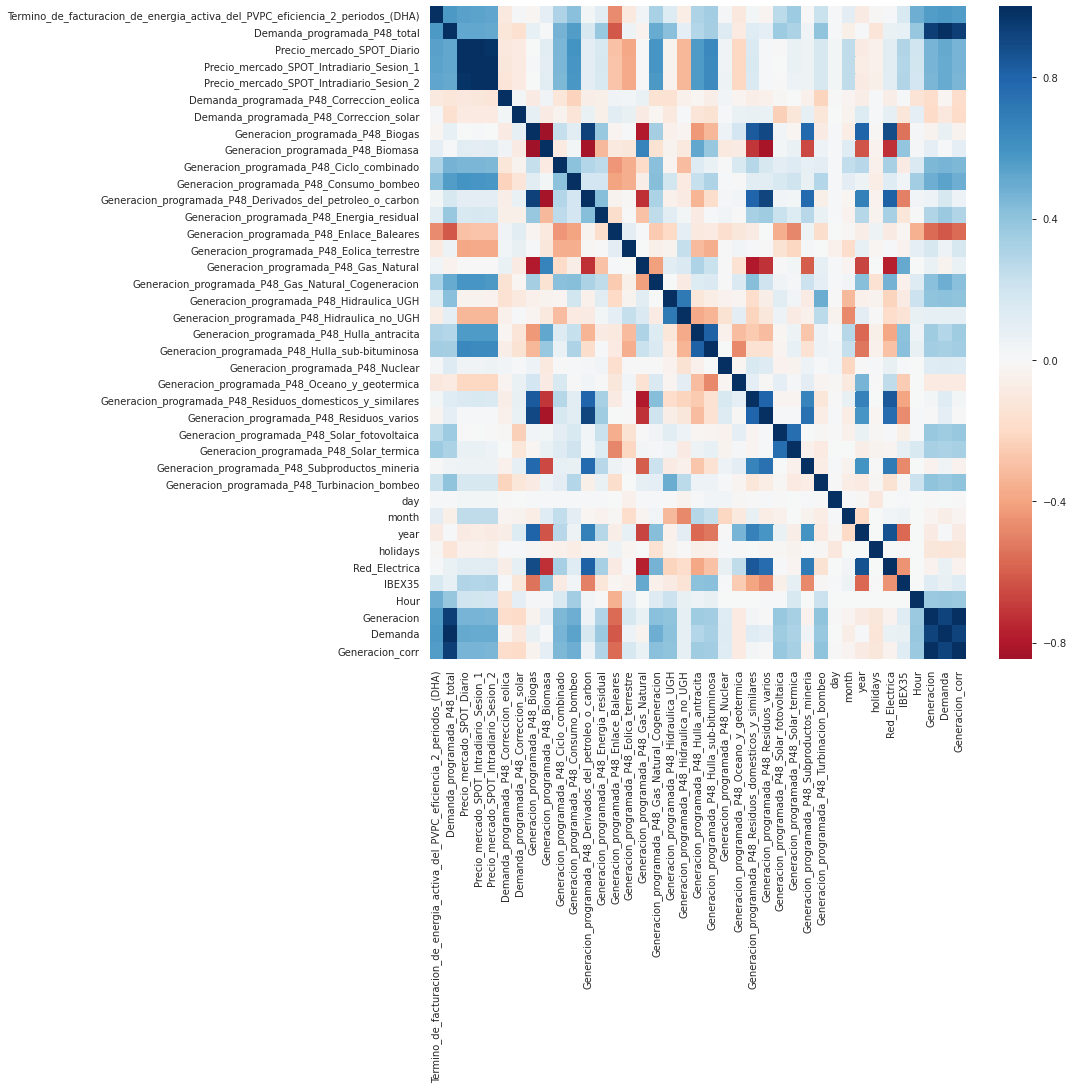

In [18]:
plt.rcParams['figure.figsize'] = [12, 12]
sns.heatmap(df.drop('Weekday',axis=1).corr(),cmap='RdBu',center=0)

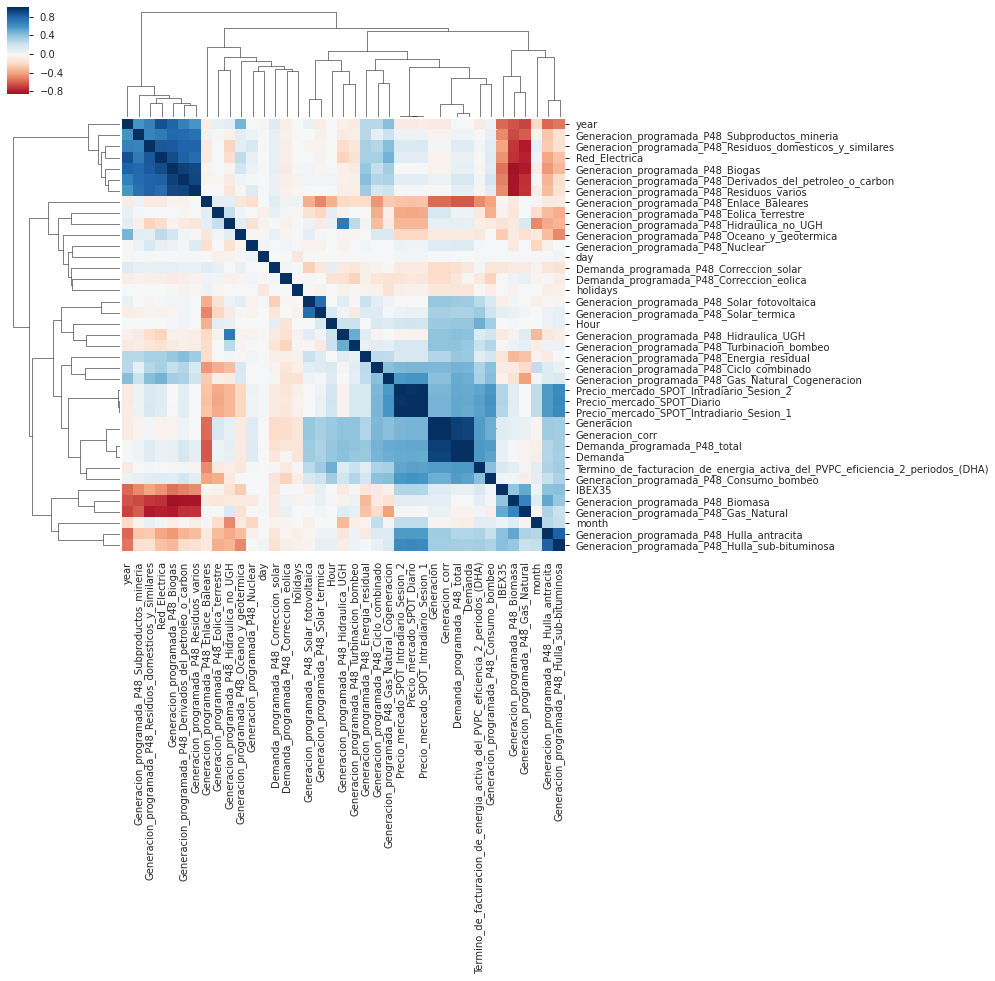

In [19]:
sns.clustermap(df.drop('Weekday',axis=1).corr(),cmap='RdBu',center=0)

In [20]:
df.to_csv('../Models/final_dataframe.csv')